# LinearRegression
- LinearRegression 클래스는 예측값과 실제 값의 RSS(Residual Sum of Squares)를 최소화해 OLS(Ordinary Least Squares)추정 방식으로 구현한 클래스
- LinearRegression 클래스는 fit( ) 메서드로 X, y배열을 입력받으면 회귀(Coefficients)인 W를 coef_속성에 저장함
![image](https://user-images.githubusercontent.com/70187490/130720900-92f12be6-f9f9-4ae5-8a26-f9596c45c12d.png)
- Ordinary Least Squares 기반의 회귀 계수 계산은 입력 피처의 독립성에 많은 영향을 받음
- 피처 간의 상관관계가 매우 높은 경우 분산이 매우 커져서 오류에 매우 민감해짐
    - 다중 공선성(Multi-collinearity)문제
- 상관관계가 높은 피처가 많은 경우 독립적인 중요한 피처만 남기고 제거하거나 규제를 적용함

# 회귀 평가 방법 메서드

|평가방법|사이킷런 평가 지표 API|Scoring 함수 적용 값|
|:-|:-|:-|
|MAE|metrics.mean_absolute_error|'neg_mean_absolute_error'|
|MSE|metrics.mean_squared_error|'neg_mean_squared_error'|
|$R^2$|metrics.r2_score|'r2|

- 사이킷런에서 RMSE를 제공하지 않기 때문에 MSE에 제곱근을 씌워서 계산해야 함
- 사이킷런의 Scoring 함수가 score 값이 클수록 좋은 평가 결과를 자동으로 평가하는 이유로 회귀 계산시에 음수값을 반환함


# LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

- 피처에 대한 설명

    - CRIM: 지역별 범죄 발생률
    - ZN: 25,000평방피트를 초과하는 거주 지역의 비율
    - INDUS: 비상업 지역 넓이 비율
    - CHAS: 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0)
    - NOX: 일산화질소 농도
    - RM: 거주할 수 있는 방 개수
    - AGE: 1940년 이전에 건축된 소유 주택의 비율
    - DIS: 5개 주요 고용센터까지의 가중 거리
    - RAD: 고속도로 접근 용이도
    - TAX: 10,000달러당 재산세율
    - PTRATIO: 지역의 교사와 학생 수 비율
    - B: 지역의 흑인 거주 비율
    - LSTAT: 하위 계층의 비율
    - MEDV: 본인 소유의 주택 가격(중앙값)
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-whitegrid'])
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns=boston.feature_names)

# boston 데이터 세트의 target 배열은 주택가격임. 이를 PRICE 컬럼을 DataFrame으로 추가함
bostonDF['PRICE']=boston.target
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [2]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


각 컬럼이 회귀 결과에 미치는 영향이 어느 정도인지를 시각화  
즉 8개의 컬럼에 대해 값이 증가할수록 PRICE가 어떻게 변화하는지를 확인

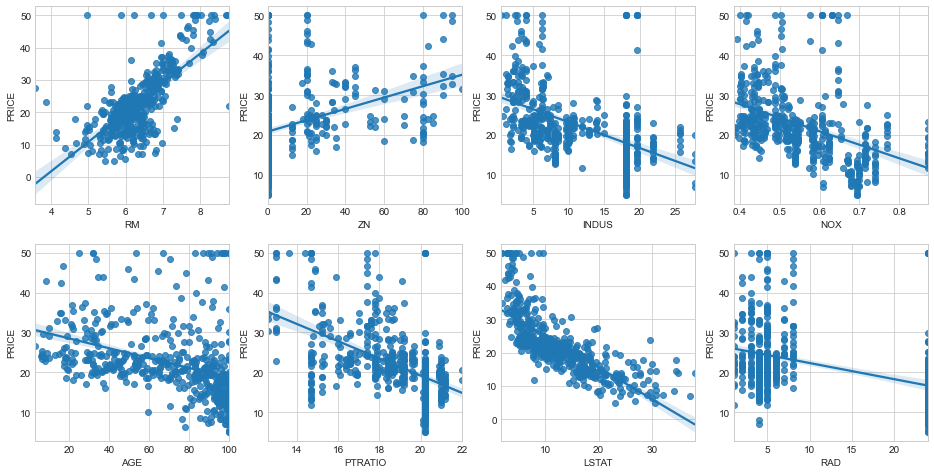

In [3]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM','ZN','INDUS','NOX',"AGE","PTRATIO","LSTAT","RAD"]
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

RM과 LSTAT의 PRICE 영향도가 가장 큼
- RM(방 개수)은 양 방향의 선형성 (Positive Linearity)가 가장큼
    - 즉 방의 크기가 클수록 가격이 증가하는 모습을 보여줌
- LSTAT(하위계층의 비율)는 음 방향의 선형성(Negative Linearity)이 가장 큼
    - LSTAT이 적을 수록 가격이 증가하는 경향

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, 
                                                    test_size=0.3, random_state=156)
# 선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse=np.sqrt(mse)

print('MSE: {0:.3f}'.format(mse))
print('RMSE: {0:.3f}'.format(rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE: 17.297
RMSE: 4.159
Variance score: 0.757


In [5]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_,1))

절편 값: 40.995595172164315
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [6]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 컬럼명의 유의
coeff = pd.Series( data=np.round(lr.coef_,1), index=X_data.columns )
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [7]:
from sklearn.model_selection import cross_val_score

# cross_val_score( )로 5 폴드 세트로 MSE 를 구한 뒤 이를 기반으로 다시 RMSE 를 구함
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring="neg_mean_squared_error", cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_err-r")로 반환된 값은 모두 음수
print(' 5 folds 의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print(' 5 folds 의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print(' 5 folds 의 평균 RMSE: {0:.3f}'.format(avg_rmse))

 5 folds 의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
 5 folds 의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
 5 folds 의 평균 RMSE: 5.829


# 다항 회귀와 과(대)적합/과소적합 이해
- 단순회귀: $y=w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 + w_3 \cdot x_2 \cdot x_3 + w_4 \cdot x_4+ w_5 \cdot x_5$과 같이 독립변수와 종속변수의 관계가 일차 방정식의 형태  
- 다항회귀: $y=w_0 + w_1 \cdot x_1 + w_2 \cdot x_2 + w_3 \cdot x_1 \cdot x_3 + w_4 \cdot {x_1}^2 + w_5 \cdot {x_2}^2$
    - 독립변수의 단항식이 아닌 2차, 3차 방정식과 같은 다항식으로 표현 됨
    - 다항회귀 또한 선형 회귀 (절대 비선형회귀라는 뜻이 아님)
    - 선형 회귀/비선형 회귀를 나누는 기준은 회귀 계수가 선형/비선형의 여부에 따라 달라짐
    - 즉 독립변수가 선형이든 비선형이든 중요하지 않음
- 사이킷런에서 다항 회귀를 위한 클래스를 명시적 제공하지 않음
    - 다항 회귀 역시 선형 회귀이기 때문에 비선형 함수를 선형 모델에 적용시키는 방법을 사용해 구현
- 사이킷런은 PolynomialFeatures 클래스를 통해 피처를 Polynomial(다항식) 피처로 변환함
- PolynomialFeatures 클래스는 degree 파라미터를 통해 입력받은 단항식 피러를 degree에 해당하는 다항식 피처로 변환함

In [10]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

# 다항식으로 변환한 단항식 생성, [[0,1], [2, 3]]의 2x2 행렬 생성
X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 피처: \n', X)

# degree=2인 2차 다항식으로 변환하기 위해 PolynomialFeatures를 이용해 변환
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 피처:\n', poly_ftr)

일차 단항식 계수 피처: 
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


- 단항 계수 피처 [ $x_1$,$x_2$ ]를 2차 다항 계수 [1, $x_1$, $x_2$, ${x_1}^2$, $x_1x_2$, ${x_2}^2$ ]로 변경
- 첫 번째 입력 단항 계수 피처 [ $x_1=0$,$x_2=1$ ]은 [1, $x_1=0$, $x_2=1$, ${x_1}^2=0$, $x_1x_2=0$, ${x_2}^2=1$ ]
- 두 번째 입력 단항 계수 피처 [ $x_1=2$,$x_2=3$ ]은 [1, $x_1=2$, $x_2=3$, ${x_1}^2=4$, $x_1x_2=6$, ${x_2}^2=9$ ]로 변환

3차 다항식 $y=1+2x_1+3{x_1}^2+4{x_2}^3$이란 식의 회귀 계수를 예측

In [13]:
def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 feature: \n', X)
y = polynomial_func(X)
print('삼차 다항식 결정값: \n', y)

일차 단항식 계수 feature: 
 [[0 1]
 [2 3]]
삼차 다항식 결정값: 
 [  5 125]


PolynomialFeatures(degree=3)을 통해 단항 계수 피처 [ $x_1$,$x_2$ ]를 3차 다항 계수 [1, $x_1$, $x_2$, ${x_1}^2$, $x_1x_2$, ${x_2}^2, {x_1}^3, {x_1}^2x_2, x_1{x_2}^2, {x_2}^3$ ]로 변경

In [14]:
# 3차 다항식 변환
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature: \n', poly_ftr)

# Linear Regression에 3차 다항식 계수 feature와 3차 다항식 결정값으로 학습 후 회귀 계수 확인
model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수\n', np.round(model.coef_, 2))
print('Polynomial 회귀 Shape:', model.coef_.shape)

3차 다항식 계수 feature: 
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape: (10,)


- 원래 다항식 $1+2x_1+3{x_1}^2+4{x_2}^3$의 계수 값: [1, 2, 0, 3, 0, 0, 0, 0, 0, 4]
- Polynomial을 통해 구해낸 회귀 계수 값: [0, 0.18, 0.18, 0.36, 0.54, 0.72, 0.72, 1.08, 1.62, 2.34]
- 차이가 존재하고 있지만 다항 회귀로 근사하고 있음  

**피처 변환과 선형 회귀 적용을 각각 별도로 하는 것보다는 Pipeline 객체를 이용해 한번에 다항 회귀를 구현하는 것이 코드를 클린하게 작성하는 방법**

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3
    return y

# Pipeline 객체로 Streamline하게 Polynomial Feature 변환과 Linear Regression을 연결
model = Pipeline([('poly',PolynomialFeatures(degree=3)),
                  ('linear', LinearRegression())])

X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)

model = model.fit(X, y)
print('Polynomial 회귀 계수 \n', np.round(model.named_steps['linear'].coef_,2))

Polynomial 회귀 계수 
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


# 다항 회귀를 이용한 과소적합 및 과적합 이해
- 다항 회귀는 피처의 직선적 관계가 아닌 복잡한 다항 관계를 모델링할 수 있다.
- 다항식의 차수가 높아질수록 매우 복잡한 피처 관계까지 모델링이 가능하지만 과적합의 가능성이 크게 늘어남  
>학습 데이터 30개의 임의의 데이터 X, X의 코사인 값에서 노이즈를 더한 target y를 이용한 회귀 예측 곡선과 예측 정확도 비교

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

# 임의의 값으로 구성된 X값에 대해 코사인 변환 값을 변환
def true_fun(X):
    return np.cos(1.5 * np.pi * X)

# X는 0부터 1까지 30개의 임의의 값을 순서대로 샘플링한 데이터
np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

# y값은 코사인 기반의 true_fun()에서 약간의 노이즈 변동 값을 더한 값
y = true_fun(X) + np.random.randn(n_samples) * 0.1

다항식 차수를 각각 1, 4, 15로 변경하면서 예측 결과를 비교
- 학습 후 cross_val_score()로 MSE 값을 구해 차수별 예측 성능 평가
- 차수별 회귀 예측 곡선


Degree 1 회귀 계수는 [-1.61] 입니다
Degree 1 MSE 는 0.40772896250986845 입니다.

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다
Degree 4 MSE 는 0.0432087498723184 입니다.

Degree 15 회귀 계수는 [-2.98294000e+03  1.03899850e+05 -1.87416981e+06  2.03717199e+07
 -1.44874017e+08  7.09319141e+08 -2.47067173e+09  6.24564702e+09
 -1.15677216e+10  1.56895933e+10 -1.54007040e+10  1.06457993e+10
 -4.91381016e+09  1.35920643e+09 -1.70382078e+08] 입니다
Degree 15 MSE 는 182581084.8263125 입니다.


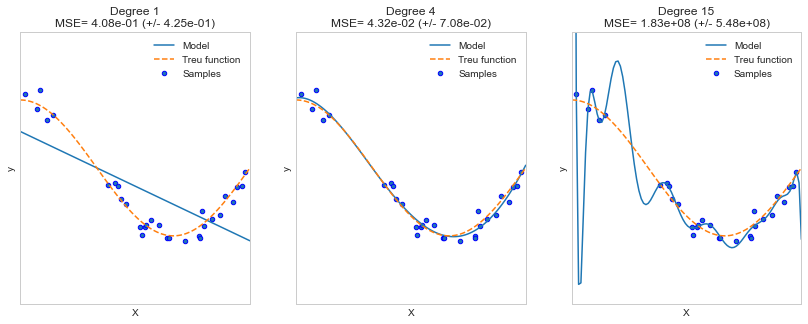

In [30]:
plt.figure(figsize=(14, 5))
degrees = [1, 4, 15]

# 다항 회귀의 차수(degree)를 1, 4, 15로 각각 변화시켜 비교
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i+1)
    plt.setp(ax, xticks=(), yticks=()) # x축, y축 눈금을 제거한다.
    
    # 개별 degree별로 Polynomial 변환
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)
    
    # 교차 검증으로 다항 회귀를 평가
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring='neg_mean_squared_error', cv=10)
    # Pipeline을 구성하는 세부 객체를 접근하는 named_steps['객체명']을 이용해 회귀계수 추출
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0} 회귀 계수는 {1} 입니다'.format(degrees[i], np.round(coefficients,2)))
    print('Degree {0} MSE 는 {1} 입니다.'.format(degrees[i], -1*np.mean(scores)))
    
    # 0부터 1까지 테스트 데이터 세트를 100개로 나눠 예측을 수행
    # 테스트 데이터 세트에 회귀 예측을 수행하고 예측 곡선과 실제 곡선을 그려 비교
    X_test = np.linspace(0, 1, 100)
    # 예측값 곡선
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    # 실제값 곡선
    plt.plot(X_test, true_fun(X_test), '--', label='Treu function')
    plt.scatter(X, y, edgecolors='b', s=20, label="Samples")
    
    plt.xlabel("X")
    plt.ylabel("y")
    plt.xlim((0,1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE= {:.2e} (+/- {:.2e})".format(degrees[i], -scores.mean(), scores.std()))
    
plt.show()

- 맨 왼쪽의 Degree 1 예측 곡선은 단순 선형 회귀와 같다. 실제 데이터 세트인 코사인 데이터 세트를 직선으로 예측하기에는 너무 단순함. 예측 곡선이 학습 데이터 패턴을 제대로 반영하지 못하고 있는 과소적합 모델. MSE는 0.407
- 가운데 Degree 4 예측 곡선은 실제 데이터 세트와 유사한 모습. 변동하는 잡음까지 예측하지 못했지만, 학습 데이터 세트를 비교적 잘 반영해 코사인 곡선 기반으로 테스트 데이터를 잘 예측함. MSE는 0.043으로 가장 뛰어난 예측 성능을 나타냄
- 맨 오른쪽 Degree15 예측 곡선은 MSE값이 무려 182581084. 예측 곡선을 보면 데이터 세트의 변동 잡음 값까지 지나치게 반영하였으므로 학습 데이터 세트만 정확히 예측하고, 테스트 값의 실제 곡선과는 상당히 다른 형태의 과적합 예측 곡선이 생성. 